In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import IPython.display as ipd

import os
import json
import math
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader

import commons
import utils
from data_utils import TextAudioLoader, TextAudioCollate, TextAudioSpeakerLoader, TextAudioSpeakerCollate
from models import SynthesizerTrn
# from text.symbols import symbols
from text import symbols
from text import text_to_sequence

from scipy.io.wavfile import write


def get_text(text, hps):
    # text_norm = text_to_sequence(text, hps.data.text_cleaners)
    text_norm = text_to_sequence(text)
    if hps.data.add_blank:
        text_norm = commons.intersperse(text_norm, 0)
    text_norm = torch.LongTensor(text_norm)
    return text_norm

In [ ]:
hps = utils.get_hparams_from_file("./configs/ljs_base.json")

In [ ]:
net_g = SynthesizerTrn(
    len(symbols),
    hps.data.filter_length // 2 + 1,
    hps.train.segment_size // hps.data.hop_length,
    **hps.model).cuda()
_ = net_g.eval()

_ = utils.load_checkpoint("/path/to/pretrained_ljs.pth", net_g, None)

In [ ]:
stn_tst = get_text("VITS is Awesome!", hps)
with torch.no_grad():
    x_tst = stn_tst.cuda().unsqueeze(0)
    x_tst_lengths = torch.LongTensor([stn_tst.size(0)]).cuda()
    audio = net_g.infer(x_tst, x_tst_lengths, noise_scale=.667, noise_scale_w=0.8, length_scale=1)[0][0,0].data.cpu().float().numpy()
ipd.display(ipd.Audio(audio, rate=hps.data.sampling_rate, normalize=False))

## KSS

In [2]:
hps = utils.get_hparams_from_file("./configs/kss_base.json")

In [3]:
net_g = SynthesizerTrn(
    len(symbols),
    hps.data.filter_length // 2 + 1,
    hps.train.segment_size // hps.data.hop_length,
    n_speakers=hps.data.n_speakers,
    **hps.model).cuda()
_ = net_g.eval()

_ = utils.load_checkpoint("/home/choihk/work/vits/logs/kss_v1/G_59000.pth", net_g, None)

INFO:root:Loaded checkpoint '/home/choihk/work/vits/logs/kss_v1/G_59000.pth' (iteration 149)


In [4]:
test = '안녕하세요? 만나서 반갑습니다.'
sid = 0
stn_tst = get_text(test, hps)
with torch.no_grad():
    x_tst = stn_tst.cuda().unsqueeze(0)
    x_tst_lengths = torch.LongTensor([stn_tst.size(0)]).cuda()
    sid = torch.LongTensor([sid]).cuda()
    audio = net_g.infer(x_tst, x_tst_lengths, sid=sid, noise_scale=.667, noise_scale_w=0.8, length_scale=1)[0][0,0].data.cpu().float().numpy()
ipd.display(ipd.Audio(audio, rate=hps.data.sampling_rate, normalize=False))

DEBUG:matplotlib.colorbar:locator: <matplotlib.ticker.AutoLocator object at 0x7f51cc77eca0>


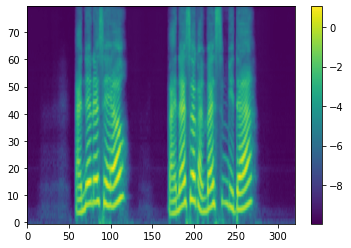

In [6]:
from mel_processing import mel_spectrogram_torch
import matplotlib.pyplot as plt

mel = mel_spectrogram_torch(
    y=torch.from_numpy(audio).unsqueeze(0), 
    n_fft=hps.data.filter_length, 
    num_mels=hps.data.n_mel_channels, 
    sampling_rate=hps.data.sampling_rate, 
    hop_size=hps.data.hop_length, 
    win_size=hps.data.win_length, 
    fmin=hps.data.mel_fmin, 
    fmax=hps.data.mel_fmax, 
    center=False
)

plt.imshow(mel.squeeze().detach().cpu().numpy(), origin='lower', aspect='auto')
plt.colorbar()
plt.show()